In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 16})
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice
import sys
import os
import time

from heisenberg_model import HeisenbergModel
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.primitive_ops import PauliSumOp

from qiskit.algorithms import NumPyEigensolver
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram



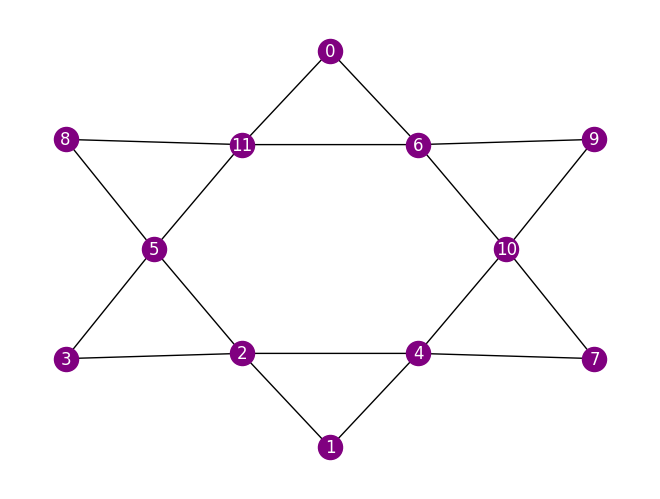

In [2]:
# Red Kagome

num_qubits = 12
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 0, t),
    (0, 6, t),
    (6, 9, t),
    (9, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 6, t),
    (6, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[0,6.8], 6:[0.6,5], 9:[1.8,5.1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 7:[1.8,0.9]}
kagome_unit_cell.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [3]:
# Hamiltoniano de la red

heis = HeisenbergModel.uniform_parameters(lattice=kagome_unit_cell,uniform_interaction=1.0,uniform_onsite_potential=0.0)
log_mapper = LogarithmicMapper()
ham=4*log_mapper.map(heis.second_q_ops().simplify())
ham


PauliSumOp(SparsePauliOp(['IZZIIIIIIIII', 'ZIIZIIIIIIII', 'IZIIZIIIIIII', 'ZIIIIZIIIIII', 'IZIIIZIIIIII', 'IIZIIZIIIIII', 'ZIIIIIZIIIII', 'IIIZIIZIIIII', 'IZIIIIIZIIII', 'IIIIZIIZIIII', 'IIIIIIZIZIII', 'IIIIIIZIIZII', 'IIIIIIIZIZII', 'IIIIIIIIZZII', 'IIIIIIIZIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IYYIIIIIIIII', 'YIIYIIIIIIII', 'IYIIYIIIIIII', 'YIIIIYIIIIII', 'IYIIIYIIIIII', 'IIYIIYIIIIII', 'YIIIIIYIIIII', 'IIIYIIYIIIII', 'IYIIIIIYIIII', 'IIIIYIIYIIII', 'IIIIIIYIYIII', 'IIIIIIYIIYII', 'IIIIIIIYIYII', 'IIIIIIIIYYII', 'IIIIIIIYIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IXXIIIIIIIII', 'XIIXIIIIIIII', 'IXIIXIIIIIII', 'XIIIIXIIIIII', 'IXIIIXIIIIII', 'IIXIIXIIIIII', 'XIIIIIXIIIII', 'IIIXIIXIIIII', 'IXIIIIIXIIII', 'IIIIXIIXIIII', 'IIIIIIXIXIII', 'IIIIIIXIIXII', 'IIIIIIIXIXII', 'IIIIIIIIXXII', 'IIIIIIIXIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

In [4]:
# Valor exacto de la energía de su estado fundamental


exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


/scratch/3499204/ipykernel_4083588/2651788360.py:4: DeprecationWarning: The class ``qiskit.algorithms.eigen_solvers.numpy_eigen_solver.NumPyEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.eigensolvers.NumPyEigensolver``. See https://qisk.it/algo_migration for a migration guide.
  exact_solver = NumPyEigensolver(k=3)


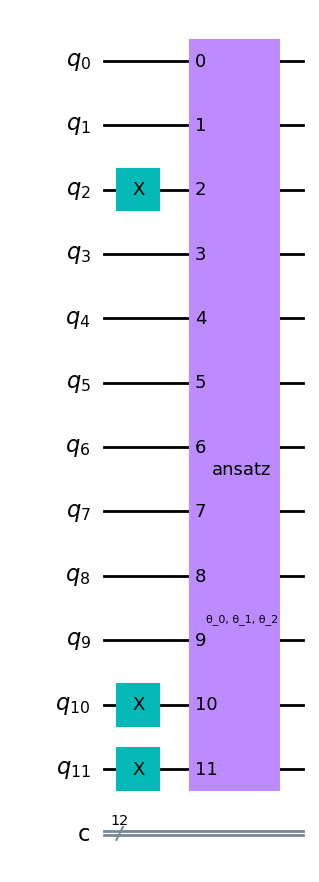

In [5]:
# Circuito cuántico

#var <- {0,1,2} = {X,Y,Z}
def add_edge_gates(qc,edge,var,param_list,p):
        [n1, n2] = [edge[0],edge[1]]
        if var == 0:
            qc.h(n1)
            qc.h(n2)
        elif var == 1:
            qc.s(n1)
            qc.h(n1)
            qc.s(n2)
            qc.h(n2)
            
        qc.cx(n1,n2)
        phi = param_list[var+3*p]
        qc.rz(phi, n2)
        qc.cx(n1,n2)
        
        if var == 0:
            qc.h(n1) 
            qc.h(n2)
        elif var == 1:
            qc.h(n1)
            qc.s(n1)
            qc.h(n2)
            qc.s(n2)

        

        
def ansatz(qc,num_qubits,k_tot):
    
    param_list = []
    num_param = get_num_param(k_tot)
    for k in range(num_param):
        param_list.append(Parameter('θ_' + str(k)))
    
    ansatz = QuantumCircuit(num_qubits,name='ansatz')
    ansatz.barrier()
    for k in range(k_tot):
        for i in range(3):
            for edge in edge_list:
                ansatz.barrier()
                add_edge_gates(ansatz,edge,i,param_list,k)
    ansatz.barrier()
    return ansatz


def add_init_state(qc):
    down_list = [11,10,2]
    for i in down_list:
        qc.x(i)
    
def get_num_param(layers):
    p = layers*3
    return p


qc = QuantumCircuit(num_qubits,num_qubits)
add_init_state(qc)

layers = 1 # Nº de capas del ansatz
num_param = get_num_param(layers)
ansatz_test = ansatz(qc,num_qubits,layers)

qc.append(ansatz_test, range(num_qubits))


qc.draw('mpl',fold=-1)



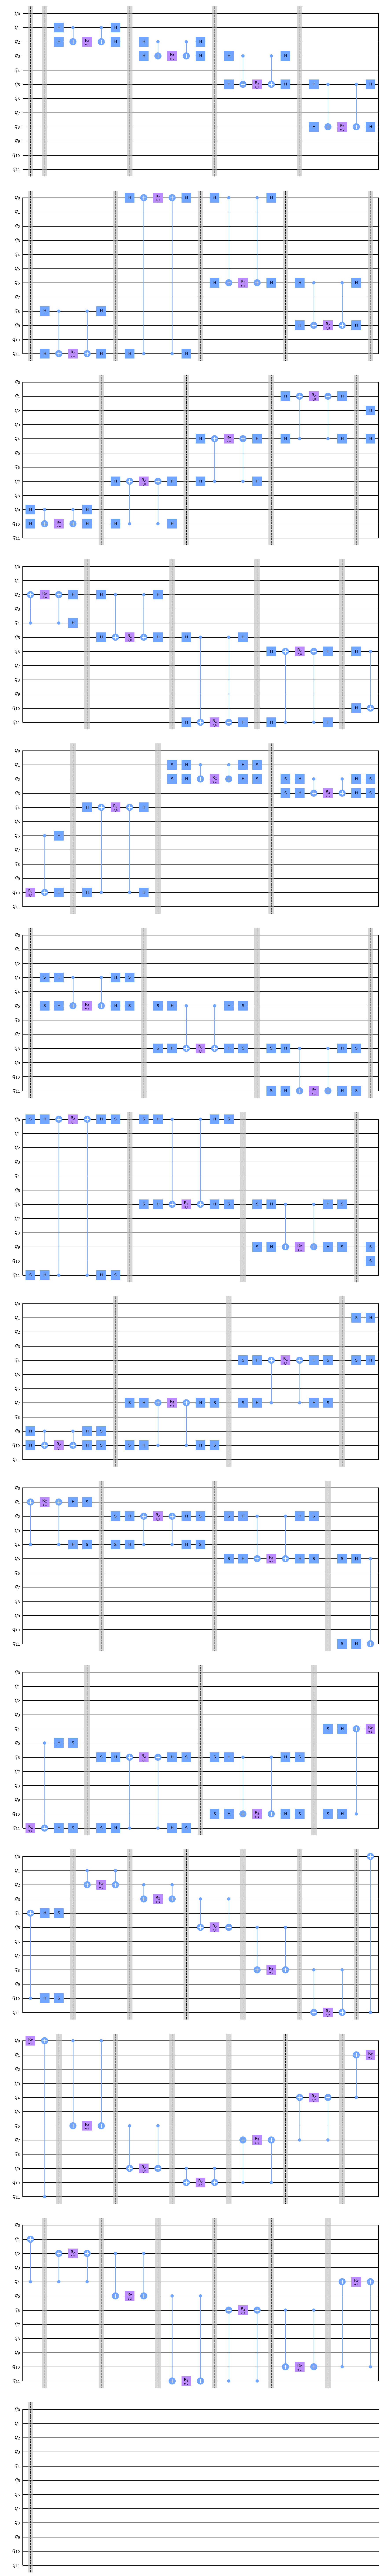

In [6]:
ansatz_test.draw('mpl')

In [7]:
qcx = qc.copy()
qcy = qc.copy()
qcz = qc.copy()

for i in range(num_qubits):
    qcx.h(i)
    qcx.measure(i,i)
for i in range(num_qubits):
    qcy.s(i)
    qcy.h(i)
    qcy.measure(i,i)
for i in range(num_qubits):
    qcz.measure(i,i)
 




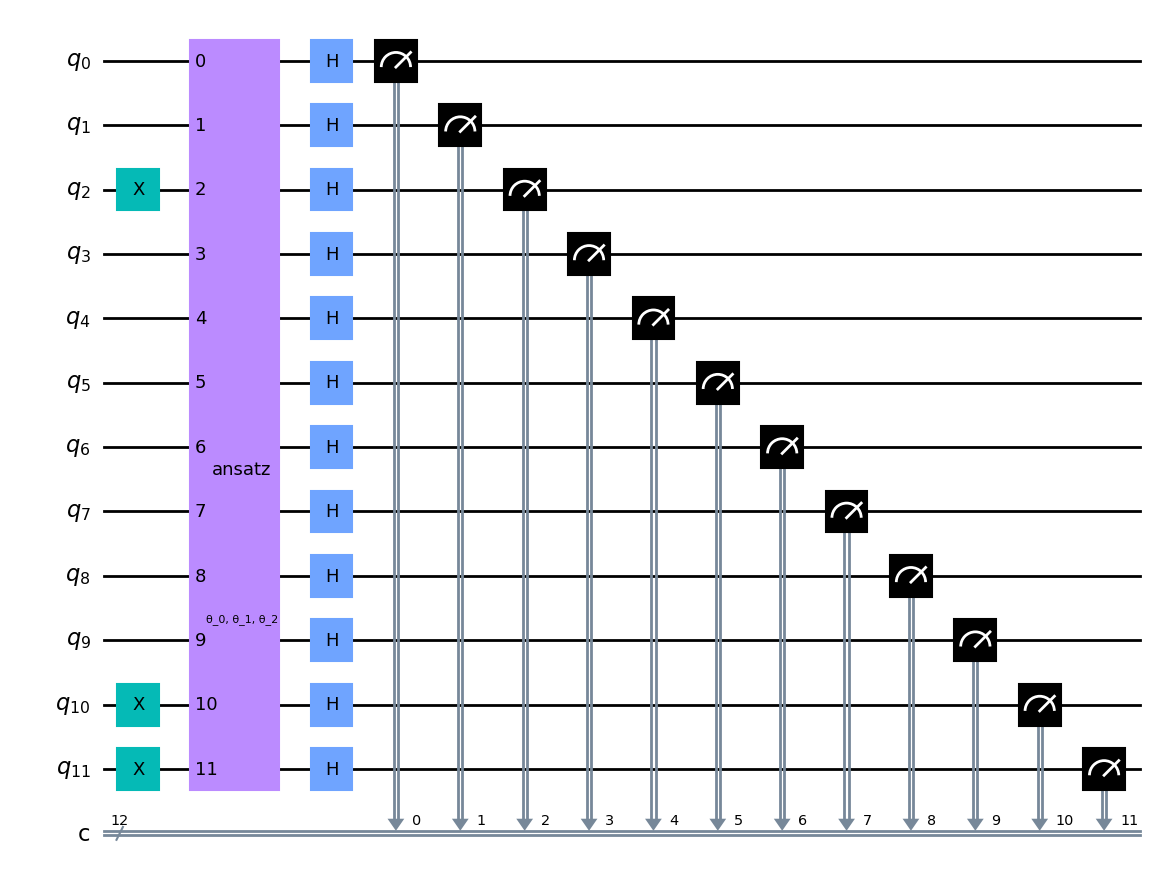

In [8]:
qcx.draw('mpl')

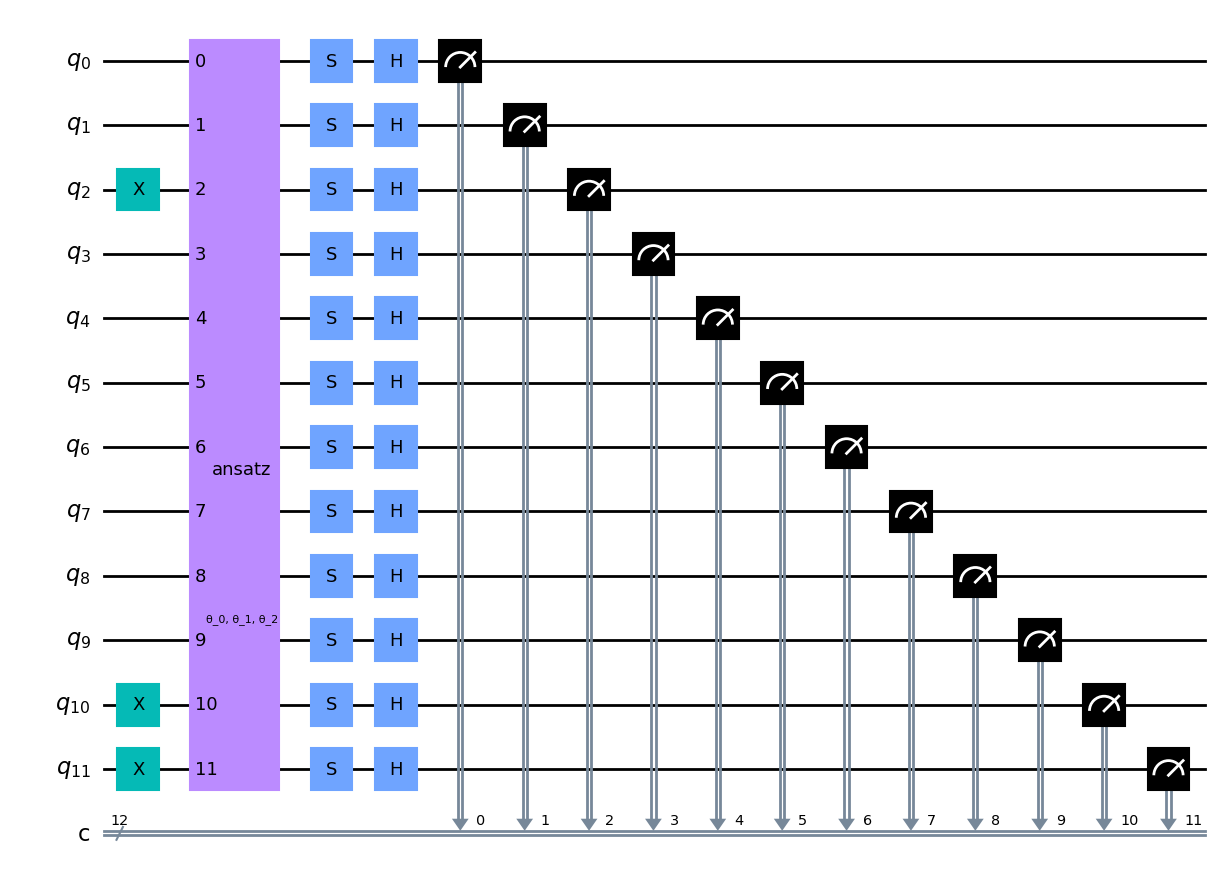

In [9]:
qcy.draw('mpl',fold=-1)

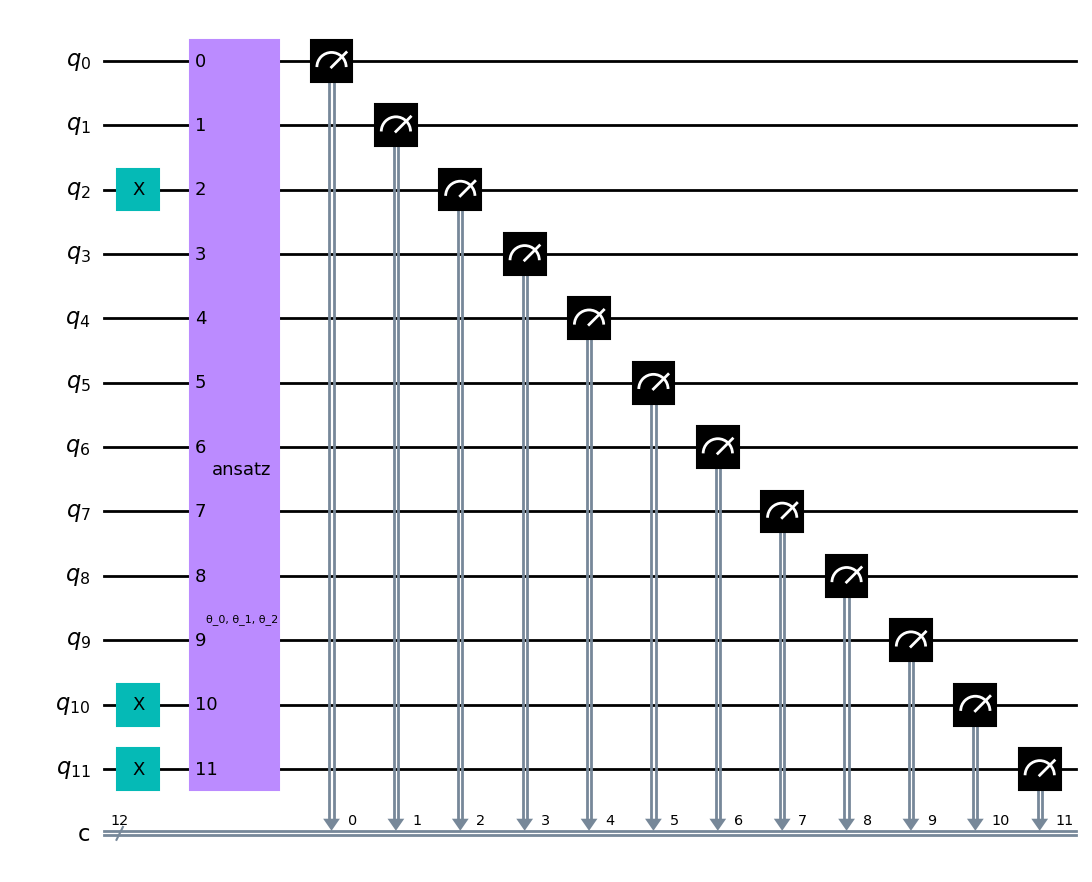

In [10]:
qcz.draw('mpl')

In [11]:
# Simulación
global aer_sim
aer_sim = Aer.get_backend('aer_simulator')
    

def sim_circ(circ,sht):
    results = aer_sim.run(circ,shots=sht).result()
    return results.get_counts()

#shots = 1000
#counts = sim_circ(qc,shots)
#plot_histogram(counts)


In [12]:
random_param = np.random.rand(num_param)*1.e-12

qcx = qcx.assign_parameters(random_param)
circx = transpile(qcx,aer_sim)

qcy = qcy.assign_parameters(random_param)
circy = transpile(qcy,aer_sim)

qcz = qcz.assign_parameters(random_param)
circz = transpile(qcz,aer_sim)

shots = 1000

countsx = sim_circ(circx,shots)
countsy = sim_circ(circy,shots)
countsz = sim_circ(circz,shots)
                  


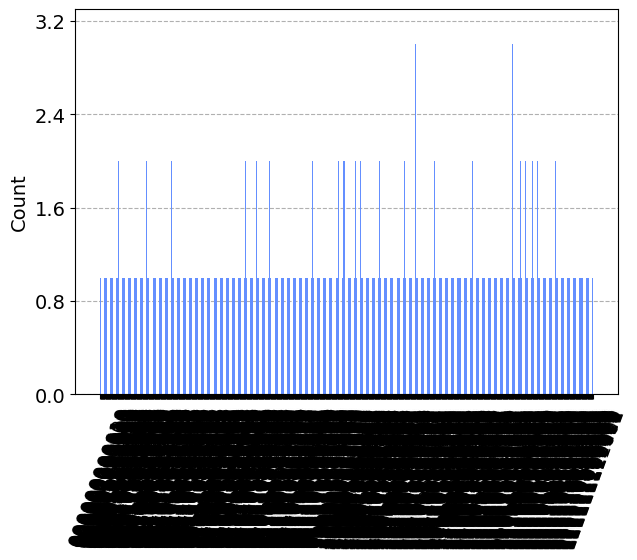

In [13]:
plot_histogram(countsx,bar_labels=False)

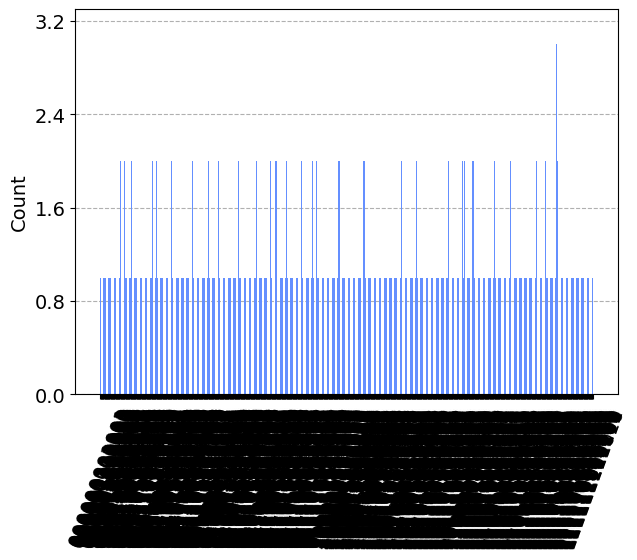

In [14]:
plot_histogram(countsy,bar_labels=False)

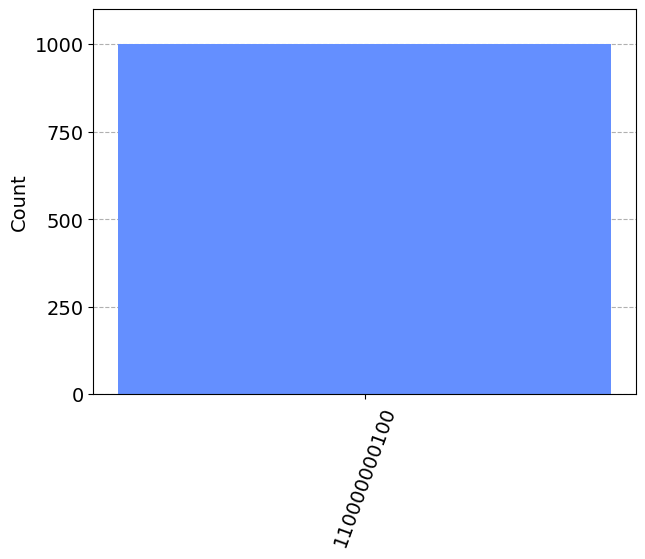

In [15]:
plot_histogram(countsz,bar_labels=False)

In [16]:
def get_energy(counts,shots,num_qubits):
    global edge_list

    energy = 0
   
    for edge in edge_list:
        for num in counts:
            factor = 1
            for n in range(len(num)):
                n_corr = len(num) - n - 1
                digit = int(num[n_corr])
                if n_corr == edge[0] or n_corr == edge[1]:
                    if digit == 1:
                        factor *= -1
                    
            energy += factor*counts[num]

                
    energy = energy/shots
        
    return energy

In [17]:
energyx = get_energy2(countsx,shots,num_qubits)
energyy = get_energy2(countsy,shots,num_qubits)
energyz = get_energy2(countsz,shots,num_qubits)
total_energy = energyx + energyy + energyz
print('Total energy:'+str(total_energy)+'| Energy x-axis:'+str(energyx)+'| Energy y-axis:'+str(energyy)+'| Energy z-axis:'+str(energyz))

NameError: name 'get_energy2' is not defined

In [ ]:
qtest = QuantumCircuit(2)
qtest.rxx(Parameter('θ'),0,1)
qtest.decompose().draw('mpl')

In [ ]:
qtest = QuantumCircuit(2)
qtest.ryy(Parameter('θ'),0,1)
qtest.decompose().draw('mpl')

In [ ]:
qtest = QuantumCircuit(2)
qtest.rzz(Parameter('θ'),0,1)
qtest.decompose().draw('mpl')

In [ ]:

def run_sim(param):
    global aer_sim
    num_qubits= 12
    layers = 6
    shots = 1000
    
    # Circuito básico: estado inicial + ansatz
    qc_circ = QuantumCircuit(num_qubits,num_qubits)
    add_init_state(qc_circ)
    ansatz_circ = ansatz(qc_circ,num_qubits,layers)
    num_param = get_num_param(layers)
    qc_circ.append(ansatz_circ, range(num_qubits))
    
    # Medición de las tres componentes del circuito
    qcx_circ = qc_circ.copy()
    for i in range(num_qubits):
        qcx_circ.h(i)
        qcx_circ.measure(i,i)
    qcx_circ = qcx_circ.assign_parameters(param)
    circx_circ = transpile(qcx_circ,aer_sim) 
    countsx_circ = sim_circ(circx_circ,shots)
    energyx_circ = get_energy(countsx_circ,shots,num_qubits)
        
    qcy_circ = qc_circ.copy()
    for i in range(num_qubits):
        qcy_circ.s(i)
        qcy_circ.h(i)
        qcy_circ.measure(i,i)
    qcy_circ = qcy_circ.assign_parameters(param)
    circy_circ = transpile(qcy_circ,aer_sim)
    countsy_circ = sim_circ(circy_circ,shots)
    energyy_circ = get_energy(countsy_circ,shots,num_qubits)

    qcz_circ = qc_circ.copy()
    for i in range(num_qubits):
        qcz_circ.measure(i,i)
    qcz_circ = qcz_circ.assign_parameters(param)
    circz_circ = transpile(qcz_circ,aer_sim)
    countsz_circ = sim_circ(circz_circ,shots)
    energyz_circ = get_energy(countsz_circ,shots,num_qubits)
    

    total_energy = energyx_circ + energyy_circ + energyz_circ
    
    print('Shots: '+str(shots))
    print('Ansatz layers: '+str(layers))
    print()
    print('Estimated energy x-axis: '+str(energyx_circ))
    print('Estimated energy y-axis: '+str(energyy_circ))
    print('Estimated energy z-axis: '+str(energyz_circ))
    print('Estimated total energy: '+str(total_energy))
    return total_energy #param

        


In [ ]:
layers = 6
random_param = np.random.rand(num_param)*1.e-12

res = run_sim(random_param)

In [ ]:
def axis_eval(qc_circ,param,ax):
    global aer_sim
    qcax_circ = qc_circ.copy()
    for i in range(num_qubits):
        if ax == 0:
            qcax_circ.h(i)

        elif ax == 1:
            qcax_circ.s(i)
            qcax_circ.h(i)

        qcax_circ.measure(i,i)

    qcax_circ = qcax_circ.assign_parameters(param)
    circax_circ = transpile(qcax_circ,aer_sim) 
    return sim_circ(circax_circ,shots)
        

def run_sim2(param):
    global aer_sim
    num_qubits= 12
    layers = 6
    shots = 1000
    
    # Circuito básico: estado inicial + ansatz
    qc_circ = QuantumCircuit(num_qubits,num_qubits)
    add_init_state(qc_circ)
    ansatz_circ = ansatz(qc_circ,num_qubits,layers)
    num_param = get_num_param(layers)
    qc_circ.append(ansatz_circ, range(num_qubits))
    
    # Medición de las tres componentes del circuito
    
    energies = [0,0,0]
    for ax in range(3):
        countsax_circ = axis_eval(qc_circ,param,ax)
        energies[ax] = get_energy(countsax_circ,shots,num_qubits)
        
    # Cálculo energía total
    total_energy = sum(energies)
    
    print('Shots: '+str(shots))
    print('Ansatz layers: '+str(layers))
    print()
    print('Estimated energy x-axis: '+str(energies[0]))
    print('Estimated energy y-axis: '+str(energies[1]))
    print('Estimated energy z-axis: '+str(energies[2]))
    print('Estimated total energy: '+str(total_energy))
    #print('Parameters: '+str(param))
    return total_energy

        


In [ ]:
layers = 6
random_param = np.random.rand(num_param)*1.e-12

res = run_sim2(random_param)
%time

In [ ]:
tensor_diag_prod(0,1,12)

In [ ]:
'0'+'1'